# Binary Simplification in Metabolomics

Notebook to support the study on the application of **Bin**ary **Sim**plification as a competing form of pre-processing procedure for high-resolution metabolomics data.

This is notebook `paper_binsim.ipynb`


## Organization of the Notebook

- Set up database of data sets
- Application of different pre-treatments (including BinSim) to each data set
- Permutation tests generation

#### Needed Imports

In [1]:
import itertools

import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

import seaborn as sns

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf

# Python files in the repository
import multianalysis as ma
from elips import plot_confidence_ellipse

In [2]:
%matplotlib inline

## Description of dataset records

`datasets` is the global dict that holds all data sets. It is a **dict of dict's**

Each data set is **represented as a dict**.

TO CONSIDER: migrate the table of datasets to a pandas DataFrame.

Each record has the following fields (keys):

- `name`: the table/figure name of the data set
- `source`: the biological source for each dataset
- `mode`: the aquisition mode
- `alignment`: the alignment used to generate the data matrix
- `data`: the data matrix
- `target`: the sample labels, possibly already integer encoded
- `<treatment name>`: transformed data matrix. These treatment names can be
    - `original`: an alias to `data`
    - `imputed`: missing value imputed data, only
    - `P`: Pareto scaled data
    - `NP`: Pareto scaled and normalized
    - `NGP`: normalized, glog transformed and Pareto scaled
    - `BinSim`: binary simplified data

The keys of `datasets` may be shared with dicts holding records resulting from comparison analysis.

Here are the keys used in this study:

- GD_neg_global2
- GD_pos_global2
- GD_neg_class2
- GD_pos_class2
- YD
- YD2
- vitis_types


#### correspondence to previously used names/variables in more focused notebooks

`aligned_all_pos` ↔ `datasets[GD_pos_global2]`

`aligned_all_neg` ↔ `datasets[GD_neg_global2]`

`aligned_all_pos2` ↔ `datasets[GD_pos_class2]`

`aligned_all_neg2` ↔ `datasets[GD_neg_class2]`

## Description of grapevine data sets

Grapevine Datasets (Negative and Positive) - 33 samples belonging to 11 different grapevine varieties (3 samples per variety/biological group).

5 different _Vitis_ species (other than _V. vinifera_) varieties:

- CAN - 3 Samples (14, 15, 16) of _V. candicans Engelmann_ (VIVC variety number: 13508)
- RIP - 3 Samples (17, 18, 19) of _V. riparia Michaux_ (Riparia Gloire de Montpellier, VIVC variety number: 4824) 
- ROT - 3 Samples (20, 21, 22) of _V. rotundifolia_ (Muscadinia Rotundifolia Michaux cv. Rotundifolia, VIVC variety number: 13586)
- RU - 3 Samples (35, 36, 37) of _V. rupestris Scheele_ (Rupestris du lot, VIVC variety number: 10389)
- LAB - 3 Samples (8, 9, 10) of _V. labrusca_ (Isabella, VIVC variety number: 5560)

6 different _V. vinifera_ cultivars varieties are:

- SYL - 3 samples (11, 12, 13) of the subspecies _sylvestris_ (VIVC variety number: -)
- CS - 3 Samples (29, 30, 31) of the subspecies _sativa_ cultivar Cabernet Sauvignon (VIVC variety number: 1929)
- PN - 3 Samples (23, 24, 25) of the subspecies _sativa_ cultivar Pinot Noir (VIVC variety number: 9279)
- REG - 3 Samples (38, 39, 40) of the subspecies _sativa_ cultivar Regent (VIVC variety number: 4572)
- RL - 3 Samples (26, 27, 28) of the subspecies _sativa_ cultivar Riesling Weiss (VIVC variety number: 10077)
- TRI - 3 Samples (32, 33, 34) of the subspecies _sativa_ cultivar Cabernet Sauvignon (VIVC variety number: 15685)

Data acquired by Marisa et al. (2020):

Maia M, Ferreira AEN, Nascimento R, et al. Integrating metabolomics and targeted gene expression to uncover potential biomarkers of fungal / oomycetes ‑ associated disease susceptibility in grapevine. Sci Rep. Published online 2020:1-15. doi:10.1038/s41598-020-72781-2

**Peak Alignment** and **Peak Filtering** was performed with function `metabolinks.peak_alignment.align()`
(see `peak_alignments.ipynb` notebook)

**4** data matrices were constructed from this data:

- 1st Filtering/Alignment: Feature present in at least two samples in the dataset - min_sample = 2 considering all samples of the dataset. This alignment, "1-2", generated two datasets one for **positive mode** data acquisition and one for **negative mode** data acquisition. These data sets are names `GD_pos_global2` and `GD_neg_global2`, respectively.
- 2nd Filtering/Alignment: Feature present in at least two of the three samples of any biological group in the dataset. 
Each group is defined by the biological replicates of each Vitis species/cultivar. This alignment, "2-1", generated two datasets one for **positive mode** data acquisition and one for **negative mode** data acquisition. These data sets are names `GD_pos_class2` and `GD_neg_class2`, respectively.

For the purpose of assessing the performance of supervised methods each of these four datasets was used with target labels defining classes corresponding to replicates of each of the 11 Vitis species/cultivars.

For the purpose of assessing the performance of supervised methods under a binary (two-class) problem, data set `GD_neg_class2` was also used with target labels defining two classes: Vitis vinifera cultivars and "wild", non-vinifera Vitis species. This is dataset `vitis_types`.

## Description of the yeast data set

The Yeast dataset, data set `YD`, was acquired by J. Luz. The Yeast dataset consists of 15 samples of FT-ICR-MS metabolomics data obtained in positive ionization mode - 3 biological replicates of 5 different strains of Saccharomyces cerevisiae : the reference strain BY4741 (represented as BY) and 4 single-gene deletion mutants of this strain – ΔGLO1, ΔGLO2, ΔGRE3 and ΔENO1. These deleted genes are directly or indirectly related to methylglyoxal metabolism.

Peak Alignment and Peak Filtering was performed with MetaboScape 4.0 software (see dissertation for details in sample preparation, pre-processing, formula assignment). In short, the peak filtering made was made by keeping all features that appeared in at least 2 samples of the full dataset.

Yeast Dataset was obtained with Electrospray Ionization in Positive Mode, Human leucine enkephalin (Sigma Aldrich) is the reference feature (internal standard) used ([M+H]+ = 556.276575 Da or [M-H]- = 554.262022 Da) and pre-processed by MetaboScape 4.0 (Bruker Daltonics) - see dissertation for details in pre-processing and formula assignment.

For the purpose of assessing the performance of supervised methods, this data set was used with target labels defining classes corresponding to replicates of each of the 4 yeast strains.

#### Loading yeast data set

In [3]:
def read_MetScape_file(filename,
                          col_renamer=None,
                          add_labels=None,
                          remove_ref_feat=None,):
    
    """Read in a MetaboScape bucket table from a CSV file."""
    
    data = pd.read_csv(filename).set_index('Bucket label')
    
    # optionally rename sample_names
    if col_renamer is not None:
        data = data.rename(columns=renamer)
    
    # optionally remove a reference feature (if already normalized)
    if remove_ref_feat is not None:
        #print(f'Feature {remove_ref_feat}\n{data.loc[remove_ref_feat, :]}\n----------')
        data = data.drop(index=[remove_ref_feat])
    
    # split in peak metadata and intensities
    peak_cols = ['m/z', 'Name', 'Formula']
    intensity_cols = [c for c in list(data.columns) if c not in peak_cols]
    peaks = data[peak_cols]
    intensities = data[intensity_cols]

    # replace zeros for NaN's
    intensities = intensities.replace(0, np.nan).dropna(how='all')
    
    # force peaks to have the same features as the (trimmed) intensities
    peaks = peaks.reindex(intensities.index)

    # optionally, add labels to intensities
    if add_labels is not None:
        intensities = mtl.add_labels(intensities, labels=add_labels)
    
    return {'filename': filename,
            'peaks':peaks,
            'intensities': intensities}

def renamer(colname):
    # Util to optionally remove all those 00000 from sample names
    return ''.join(colname.split('00000'))

In [4]:
# Labels of the 5 biological groups (5 yeast strains) - only added after
yeast_classes = 'WT ΔGRE3 ΔENO1 ΔGLO1 ΔGLO2'.split()

In [5]:
# Read in the file and keep results in dicts 

prefix_to_drop = None # change to 'ENO' to remove ENO strain

# MScape non-normalized dataset
MS_data = read_MetScape_file('5yeasts_notnorm.csv', 
                             remove_ref_feat=None,
                             add_labels=None,
                             col_renamer=renamer)

#MS_data

In [6]:
# keep features that appear in at least two samples
yeast_datamatrix = transf.keep_atleast(MS_data['intensities'].transpose(), minimum=2)
yeast_datamatrix

Bucket label,307.0838178877 Da,555.2692975341 Da,624.0873082632 Da,493.3168156897 Da,257.1028750516 Da,780.1092067055 Da,347.0630811124 Da,254.2246098628 Da,625.0869294704 Da,663.1091419334 Da,...,554.6687988435 Da,851.6819663479 Da,352.0866584613 Da,554.6387493588 Da,533.0467313042 Da,892.5313342202 Da,847.0028787316 Da,535.6351204857 Da,547.4252442854 Da,299.0852986149 Da
BY0_1,391042880.0,111270160.0,130088936.0,106187168.0,54234476.0,33863468.0,35209136.0,9935943.0,25313166.0,21631346.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BY0_2,398003680.0,110423984.0,127133608.0,109233816.0,53720908.0,32622178.0,35636648.0,17679414.0,24989162.0,24420090.0,...,557228.3750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BY0_3,399481952.0,111225424.0,131208568.0,111553216.0,55826148.0,34655496.0,37943456.0,19530026.0,24684334.0,24862190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GRE3_1,270906400.0,92849040.0,130682664.0,104352720.0,46503348.0,33206608.0,32640452.0,5713388.5,25890872.0,28692028.0,...,NaN,NaN,NaN,NaN,NaN,548196.50,NaN,NaN,NaN,NaN
GRE3_2,271023520.0,94888320.0,130844488.0,107277600.0,44828256.0,34597444.0,31696134.0,10139615.0,25548978.0,26964150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GRE3_3,274854272.0,94514272.0,130896568.0,109619152.0,46361588.0,33131336.0,31668180.0,16434200.0,25518902.0,26654308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENO1_1,255276736.0,150620544.0,136612464.0,31276910.0,72465536.0,35298204.0,31236114.0,10759292.0,25798230.0,22221992.0,...,NaN,540980.9375,NaN,543241.1875,NaN,NaN,NaN,551425.1250,NaN,NaN
ENO1_2,251610656.0,148516304.0,134972800.0,31337604.0,70376640.0,35198252.0,30789652.0,25896608.0,26849502.0,23433602.0,...,NaN,NaN,562062.625,NaN,NaN,NaN,549861.4375,NaN,553295.750,545085.3750
ENO1_3,251024624.0,150645840.0,135922432.0,31644646.0,68912816.0,34380756.0,30916958.0,29723808.0,26606410.0,23500090.0,...,NaN,NaN,540392.625,NaN,550756.625,NaN,NaN,NaN,NaN,545906.1875
dGLO1_1,283822048.0,202869216.0,130259064.0,39904768.0,58269456.0,32095004.0,29669478.0,26538900.0,26013280.0,21245436.0,...,NaN,NaN,NaN,558994.1250,548675.125,NaN,NaN,NaN,NaN,NaN


### Building data-sets data base

In [7]:
datasets = {}
# From the alignments_new store

data_df = pd.HDFStore('alignments_new.h5').get('all_1ppm_min2_neg').transpose()
gd_labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

datasets['GD_neg_global2'] = {'source': 'grapevine',
                              'alignment': '1-2',
                              'mode': '-',
                              'name': 'GDg2-',
                              'data': data_df,
                              'original': data_df,
                              'target': gd_labels,
                              'classes': list(pd.unique(gd_labels))}


data_df = pd.HDFStore('alignments_new.h5').get('all_1ppm_min2_pos').transpose()
labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

datasets['GD_pos_global2'] = {'source': 'grapevine',
                              'alignment': '1-2',
                              'mode': '+',
                              'name': 'GDg2+',
                              'data': data_df,
                              'original': data_df,
                              'target': gd_labels,
                              'classes': list(pd.unique(gd_labels))}

data_df = pd.HDFStore('alignments_new.h5').get('groups_1ppm_min2_all_1ppm_neg').transpose()
labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

datasets['GD_neg_class2'] = {'source': 'grapevine',
                              'alignment': '2-1',
                              'mode': '-',
                              'name': 'GDc2-',
                              'data': data_df,
                              'original': data_df,
                              'target': gd_labels,
                              'classes': list(pd.unique(gd_labels))}

data_df = pd.HDFStore('alignments_new.h5').get('groups_1ppm_min2_all_1ppm_pos').transpose()
labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

datasets['GD_pos_class2'] = {'source': 'grapevine',
                              'alignment': '2-1',
                              'mode': '+',
                              'name': 'GDc2+',
                              'data': data_df,
                              'original': data_df,
                              'target': gd_labels,
                              'classes': list(pd.unique(gd_labels))}

yeast_labels = [item for item in yeast_classes for i in range(3)]

datasets['YD'] = {'source': 'yeast',
                            'alignment': '1-2',
                            'mode': '+',
                            'name': 'YD 2/15',
                            'data': yeast_datamatrix,
                            'original': yeast_datamatrix,
                            'target': yeast_labels,
                            'classes': list(pd.unique(yeast_labels))}

min_non_na = '6/15'

yeast_datamatrix_less_na = transf.keep_atleast(yeast_datamatrix, minimum=eval(min_non_na))

datasets['YD2'] = {'source': 'yeast',
                            f'alignment': 'at_least {min_non_na}',
                            'mode': '+',
                            'name': 'YD ' + min_non_na,
                            'data': yeast_datamatrix_less_na,
                            'original': yeast_datamatrix_less_na,
                            'target': yeast_labels,
                            'classes': list(pd.unique(yeast_labels))}

vitis_types = {'CAN': 'wild', 'RIP': 'wild', 'ROT': 'wild','RU': 'wild', 'LAB': 'wild',
               'SYL': 'wild','REG': 'vinifera','CS': 'vinifera','PN': 'vinifera','RL': 'vinifera',
               'TRI': 'vinifera'}

gd_type_labels = [vitis_types[lbl] for lbl in gd_labels]

datasets['vitis_types'] = {'source': 'grapevine',
                            'alignment': '2-1',
                            'mode': '-',
                            'name': 'Vitis types',
                            'data': datasets['GD_neg_class2']['original'],
                            'original': datasets['GD_neg_class2']['original'],
                            'target': gd_type_labels,
                            'classes': list(pd.unique(gd_type_labels))}

print('target for grapevine 11-variety data sets')
print(datasets['GD_neg_global2']['target'])
print('------\ntarget for 4 yeast strains data set')
print(datasets['YD']['target'])
print('------\ntarget for 2-class wild Vitis vs Vitis vinifera data set')
print(datasets['vitis_types']['target'])

target for grapevine 11-variety data sets
['CAN', 'CAN', 'CAN', 'CS', 'CS', 'CS', 'LAB', 'LAB', 'LAB', 'PN', 'PN', 'PN', 'REG', 'REG', 'REG', 'RIP', 'RIP', 'RIP', 'RL', 'RL', 'RL', 'ROT', 'ROT', 'ROT', 'RU', 'RU', 'RU', 'SYL', 'SYL', 'SYL', 'TRI', 'TRI', 'TRI']
------
target for 4 yeast strains data set
['WT', 'WT', 'WT', 'ΔGRE3', 'ΔGRE3', 'ΔGRE3', 'ΔENO1', 'ΔENO1', 'ΔENO1', 'ΔGLO1', 'ΔGLO1', 'ΔGLO1', 'ΔGLO2', 'ΔGLO2', 'ΔGLO2']
------
target for 2-class wild Vitis vs Vitis vinifera data set
['wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera', 'wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera', 'vinifera', 'vinifera', 'vinifera', 'wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera']


In [8]:
datasets['YD2']['data']

Bucket label,307.0838178877 Da,555.2692975341 Da,624.0873082632 Da,493.3168156897 Da,257.1028750516 Da,780.1092067055 Da,347.0630811124 Da,254.2246098628 Da,625.0869294704 Da,663.1091419334 Da,...,229.2123516866 Da,394.1157975983 Da,379.1049581299 Da,248.0382813898 Da,355.6157973903 Da,234.1618657562 Da,384.2188536141 Da,561.1740363894 Da,384.1550071491 Da,486.1583934820 Da
BY0_1,391042880.0,111270160.0,130088936.0,106187168.0,54234476.0,33863468.0,35209136.0,9935943.0,25313166.0,21631346.0,...,NaN,772182.5000,NaN,594449.9375,698648.0000,NaN,NaN,704317.1875,NaN,NaN
BY0_2,398003680.0,110423984.0,127133608.0,109233816.0,53720908.0,32622178.0,35636648.0,17679414.0,24989162.0,24420090.0,...,NaN,601594.2500,616405.1875,573408.3125,NaN,NaN,591270.6875,594117.8125,NaN,NaN
BY0_3,399481952.0,111225424.0,131208568.0,111553216.0,55826148.0,34655496.0,37943456.0,19530026.0,24684334.0,24862190.0,...,NaN,748387.5625,661618.0625,NaN,NaN,577509.4375,628977.9375,NaN,NaN,592246.8125
GRE3_1,270906400.0,92849040.0,130682664.0,104352720.0,46503348.0,33206608.0,32640452.0,5713388.5,25890872.0,28692028.0,...,NaN,670217.1250,NaN,582062.5000,NaN,NaN,NaN,NaN,561696.1875,NaN
GRE3_2,271023520.0,94888320.0,130844488.0,107277600.0,44828256.0,34597444.0,31696134.0,10139615.0,25548978.0,26964150.0,...,NaN,NaN,NaN,883340.5000,NaN,NaN,NaN,NaN,601161.2500,559238.4375
GRE3_3,274854272.0,94514272.0,130896568.0,109619152.0,46361588.0,33131336.0,31668180.0,16434200.0,25518902.0,26654308.0,...,562025.3125,NaN,NaN,556031.8125,NaN,NaN,NaN,NaN,681038.2500,558403.9375
ENO1_1,255276736.0,150620544.0,136612464.0,31276910.0,72465536.0,35298204.0,31236114.0,10759292.0,25798230.0,22221992.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,580237.7500,NaN,NaN
ENO1_2,251610656.0,148516304.0,134972800.0,31337604.0,70376640.0,35198252.0,30789652.0,25896608.0,26849502.0,23433602.0,...,NaN,NaN,NaN,NaN,NaN,657626.3125,NaN,NaN,NaN,NaN
ENO1_3,251024624.0,150645840.0,135922432.0,31644646.0,68912816.0,34380756.0,30916958.0,29723808.0,26606410.0,23500090.0,...,597902.5000,NaN,594469.9375,NaN,NaN,NaN,664188.5000,597523.3125,NaN,NaN
dGLO1_1,283822048.0,202869216.0,130259064.0,39904768.0,58269456.0,32095004.0,29669478.0,26538900.0,26013280.0,21245436.0,...,664256.5000,NaN,NaN,618080.8125,540651.7500,607250.8125,590962.6250,569196.3750,NaN,704541.7500


### Colors for plots to ensure consistency

#### 11- variety grapevine data sets

In [9]:
# customize label colors for 11 grapevine varieties

colours = sns.color_palette('Blues', 3)
colours.extend(sns.color_palette('Greens', 3))
#colours = sns.cubehelix_palette(n_colors=6, start=2, rot=0, dark=0.2, light=.9, reverse=True)
colours.extend(sns.color_palette('flare', 5))

ordered_vitis_labels = ('CAN','RIP','ROT','RU','LAB','SYL','REG','CS','PN','RL','TRI')

vitis_label_colors = {lbl: c for lbl, c in zip(ordered_vitis_labels, colours)}

tab20bcols = sns.color_palette('tab20b', 20)
tab20ccols = sns.color_palette('tab20c', 20)
tab20cols = sns.color_palette('tab20', 20)
tab10cols = sns.color_palette('tab10', 10)
dark2cols = sns.color_palette('Dark2', 8)

vitis_label_colors['RU'] = tab20bcols[8]
vitis_label_colors['CAN'] = tab20ccols[5]
vitis_label_colors['REG'] = tab10cols[3]

for name in datasets:
    if name.startswith('GD'):
        datasets[name]['label_colors'] = vitis_label_colors
        datasets[name]['sample_colors'] = [vitis_label_colors[lbl] for lbl in datasets[name]['target']]

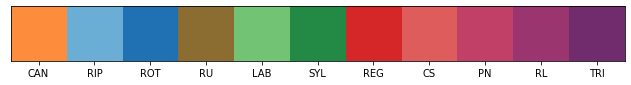

In [10]:
sns.palplot(vitis_label_colors.values())
new_ticks = plt.xticks(range(len(ordered_vitis_labels)), ordered_vitis_labels)

#### 5 yeast strains

In [11]:
# customize label colors for 5 yeast strains

colours = sns.color_palette('Set1', 5)
yeast_label_colors = {lbl: c for lbl, c in zip(yeast_classes, colours)}
datasets['YD']['label_colors'] = yeast_label_colors
datasets['YD']['sample_colors'] = [yeast_label_colors[lbl] for lbl in datasets['YD']['target']]
datasets['YD2']['label_colors'] = yeast_label_colors
datasets['YD2']['sample_colors'] = [yeast_label_colors[lbl] for lbl in datasets['YD2']['target']]

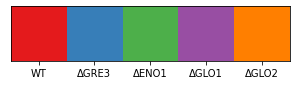

In [12]:
sns.palplot(yeast_label_colors.values())
new_ticks = plt.xticks(range(len(yeast_classes)), yeast_classes)

#### 2 classes of Vitis types

In [13]:
# customize label colors for 2 types of Vitis varieties

colours = [vitis_label_colors['SYL'], vitis_label_colors['TRI']]
vitis_type_classes = datasets['vitis_types']['classes']
vitis_types_label_colors = {lbl: c for lbl, c in zip(vitis_type_classes, colours)}
datasets['vitis_types']['label_colors'] = vitis_types_label_colors
datasets['vitis_types']['sample_colors'] = [vitis_types_label_colors[lbl] for lbl in datasets['vitis_types']['target']]

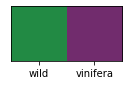

In [14]:
sns.palplot(datasets['vitis_types']['label_colors'].values())
new_ticks = plt.xticks(range(len(datasets['vitis_types']['classes'])), datasets['vitis_types']['classes'])

In [15]:
def styled_sample_labels(sample_names, sample_labels, label_colors):

    meta_table = pd.DataFrame({'label': sample_labels,
                               'sample': sample_names}).set_index('sample').T

    def apply_label_color(val):
        red, green, blue = label_colors[val]
        red, green, blue = int(red*255), int(green*255), int(blue*255)   
        hexcode = '#%02x%02x%02x' % (red, green, blue)
        css = f'background-color: {hexcode}'
        return css
    
    return meta_table.style.applymap(apply_label_color)

In [16]:
parsed = mtl.parse_data(datasets['GD_pos_class2']['data'], labels_loc='label')
y = datasets['GD_pos_class2']['target']
label_colors = datasets['GD_pos_class2']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,CAN,CAN,CAN,CS,CS,CS,LAB,LAB,LAB,PN,PN,PN,REG,REG,REG,RIP,RIP,RIP,RL,RL,RL,ROT,ROT,ROT,RU,RU,RU,SYL,SYL,SYL,TRI,TRI,TRI


In [17]:
parsed = mtl.parse_data(datasets['YD']['data'])
y = datasets['YD']['target']
label_colors = datasets['YD']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
label,WT,WT,WT,ΔGRE3,ΔGRE3,ΔGRE3,ΔENO1,ΔENO1,ΔENO1,ΔGLO1,ΔGLO1,ΔGLO1,ΔGLO2,ΔGLO2,ΔGLO2


In [18]:
parsed = mtl.parse_data(datasets['vitis_types']['data'], labels_loc='label')
y = datasets['vitis_types']['target']
label_colors = datasets['vitis_types']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,wild,wild,wild,wild,wild,wild,vinifera,vinifera,vinifera


## Data transformations and pre-treatments

### Each Dataset is transformed to binary or treated by a combination of more established treatments


### Traditional Pre-Treatments

All samples need to have missing value imputation (removing features is optional). In this case, missing features were replaced with half of the minimum intensity of the full dataset.

This can be done with the `NaN_Imputation` function of scaling.py or `fillna_frac_min`(more options available) from metabolinks.

#### 3/4 types of combinations of traditional pre-treatments are made:

(Imp (Ionly) - Only Missing Value Imputation).

##### P Treatment - Missing Value Imputation and Pareto Scaling.

##### NP Treatment - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

##### NGP Treatment - Missing Value Imputation, Normalization by reference feature, Generalized Logarithmic Transformation and Pareto Scaling.

Note: Leucine Enkephalin peak is removed upon normalization.

### Binary Simplification (BinSim)

##### BinSim - `df_to_bool` function (very simple)

In [19]:
# Represents Binary Similarity pre-treatment
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)


def compute_transf(dataset, norm_ref=None, lamb=None):
    "Computes 3 combinations of pre-treatments and BinSim and returns after treatment datasets in a dict."
    
    data = dataset['data']
    
    # Imputation of Missing Values
    imputed = transf.fillna_frac_min(data, fraction=0.5)
    
    # Normalization by a reference feature
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    
    # Pareto Scaling and Generalized Logarithmic Transformation
    P = transf.pareto_scale(imputed)
    NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))
    
    # Store results
    dataset['BinSim'] = df_to_bool(data)
    dataset['Ionly'] = imputed
    dataset['P'] = P
    dataset['NP'] = NP
    dataset['NGP'] = NGP

Human leucine enkephalin (Sigma Aldrich) is the reference feature (internal standard) used for these datasets

[M+H]+ = 556.276575 Da or [M-H]- = 554.262022 Da

Search in the Negative GD and Positive GD for the reference feature with `search_for_ref_feat` (details in scaling.py).

### 1st Filtering/Alignment - 1-2 (used in dissertation)

#### Performing different combinations of pre-treatments for the Negative and Positive GD

Search for the reference feature.

In [20]:
# Theoretical mass for negative mode Leucine Enkephalin - 554.262022
# Theoretical mass for positive mode Leucine Enkephalin - 556.276575
Leu_Enk_neg = 554.262022
Leu_Enk_pos = 556.276575

# Reference Feature in the yeast dataset
leu_enk_name = '555.2692975341 Da'

In [21]:
query_datasets = [name for name in datasets if datasets[name]['source']=='grapevine']

for name in query_datasets:
    ds = datasets[name]
    print(f'looking for reference in {name} ...')
    ref_variable = Leu_Enk_neg if ds['mode'] == '-' else Leu_Enk_pos
    closest = transf.find_closest_features(ds['data'], features=[ref_variable])
    if closest[ref_variable] is not None:
        print('Found ref feature', ref_variable)
        delta = closest[ref_variable] - ref_variable
        print(f'In data: {closest[ref_variable]} delta = {delta:.3e}\n')

query_datasets = [name for name in datasets if name.startswith('YD')]

ref_variable = leu_enk_name
for name in query_datasets:
    ds = datasets[name]
    print(f'looking for reference in {name} ...') 
    closest = transf.find_closest_features(ds['data'], features=[ref_variable])
    if closest[ref_variable] is not None:
        print('Found ref feature', ref_variable, '\n')
    else:
        print('Ref feature not found\n')

looking for reference in GD_neg_global2 ...
Found ref feature 554.262022
In data: 554.26202 delta = -2.000e-06

looking for reference in GD_pos_global2 ...
Found ref feature 556.276575
In data: 556.27657 delta = -5.000e-06

looking for reference in GD_neg_class2 ...
Found ref feature 554.262022
In data: 554.26202 delta = -2.000e-06

looking for reference in GD_pos_class2 ...
Found ref feature 556.276575
In data: 556.27657 delta = -5.000e-06

looking for reference in vitis_types ...
Found ref feature 554.262022
In data: 554.26202 delta = -2.000e-06

looking for reference in YD ...
Found ref feature 555.2692975341 Da 

looking for reference in YD2 ...
Found ref feature 555.2692975341 Da 



Apply the different pre-treatments and get the results in their respective dictionaries

In [22]:
for name, ds in datasets.items():
    print(f'Applying pre-processing transformations to data in {name}', end=' ...')
    if name.startswith('YD'):
        ref_variable = leu_enk_name
    else:
        ref_variable = Leu_Enk_neg if ds['mode'] == '-' else Leu_Enk_pos
    
    compute_transf(ds, norm_ref=ref_variable)
    print('done!')

Applying pre-processing transformations to data in GD_neg_global2 ...done!
Applying pre-processing transformations to data in GD_pos_global2 ...done!
Applying pre-processing transformations to data in GD_neg_class2 ...done!
Applying pre-processing transformations to data in GD_pos_class2 ...done!
Applying pre-processing transformations to data in YD ...done!
Applying pre-processing transformations to data in YD2 ...done!
Applying pre-processing transformations to data in vitis_types ...done!


## Supervised Statistical Analysis

The Supervised Statistical Analysis methods used will be Random Forest and PLS-DA.

The performance of the classifiers will be evaluated by their predictive **accuracy** (which will always be estimated by internal stratified 3-fold cross-validation or 5 -fold cross-validation in vitis_types).

## Permutation Tests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is Random Forest or PLS-DA found a significant class structure in the data - assess the significance of the predictive accuracy results. 

For that a random 3-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 1000 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

### Permutation Tests - Random Forests

Use of `permutation_RF` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [23]:
# json for persistence

import json
from time import perf_counter

Use `GENERATE = True` to perform permutation tests and persist results in json

In [24]:
GENERATE = False

In [30]:
if GENERATE:
    iter_num=500 # number of permutations


    permuts_RF = []

    to_permute = [name for name in datasets]# if 'global2' in name]
    for name in to_permute:
        for treatment in ('P', 'NP', 'NGP', 'BinSim'):
            dataset = datasets[name]
            print(f'{iter_num} permutations (Random Forest) for {name} with treatment {treatment}', end=' ...')
            n_fold = 5 if name == 'vitis_types' else 3
            start = perf_counter()
            permutations = ma.permutation_RF(dataset[treatment], dataset['target'], iter_num=iter_num, n_fold=n_fold, n_trees=100)
            res = {'dataset': name, 'treatment': treatment,
                   'non_permuted_CV': permutations[0],
                   'permutations': permutations[1],
                   'p-value': permutations[2]}       
            permuts_RF.append(res)
            end = perf_counter()
            print(f'Done! took {(end - start):.3f} s')

    fname = 'permuts/permuts_rf.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(permuts_RF, write_file)

500 permutations (Random Forest) for GD_neg_global2 with treatment P ...Done! took 203.279 s
500 permutations (Random Forest) for GD_neg_global2 with treatment NP ...Done! took 217.011 s
500 permutations (Random Forest) for GD_neg_global2 with treatment NGP ...Done! took 217.454 s
500 permutations (Random Forest) for GD_neg_global2 with treatment BinSim ...Done! took 205.516 s
500 permutations (Random Forest) for GD_pos_global2 with treatment P ...Done! took 249.120 s
500 permutations (Random Forest) for GD_pos_global2 with treatment NP ...Done! took 279.882 s
500 permutations (Random Forest) for GD_pos_global2 with treatment NGP ...Done! took 274.214 s
500 permutations (Random Forest) for GD_pos_global2 with treatment BinSim ...Done! took 248.160 s
500 permutations (Random Forest) for GD_neg_class2 with treatment P ...Done! took 192.610 s
500 permutations (Random Forest) for GD_neg_class2 with treatment NP ...Done! took 203.983 s
500 permutations (Random Forest) for GD_neg_class2 with

### Permutation Tests - PLS-DA (slow)

Use of `permutation_PLSDA` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [32]:
%%capture --no-stdout
if GENERATE:
    iter_num=500

    permuts_PLSDA = []

    to_permute = [name for name in datasets] # if 'global2' in name]
    for name in to_permute:
        for treatment in ('P', 'NP', 'NGP', 'BinSim'):
            dataset = datasets[name]
            print(f'Permutation test (PLS-DA) for {name} with treatment {treatment}', end=' ...')
            n_comp = 11 if name.startswith('GD') else 6
            n_fold = 5 if name == 'vitis_types' else 3
            start = perf_counter()
            permutations = ma.permutation_PLSDA(dataset[treatment], dataset['target'], n_comp=11,
                                                iter_num=iter_num, n_fold=n_fold)
            res = {'dataset': name, 'treatment': treatment,
                   'non_permuted_CV': permutations[0],
                   'permutations': permutations[1],
                   'p-value': permutations[2]}
            permuts_PLSDA.append(res)
            end = perf_counter()
            print(f'Done! took {(end - start):.3f} s')
    fname = 'permuts/permuts_plsda.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(permuts_PLSDA, write_file)

Permutation test (PLS-DA) for GD_neg_global2 with treatment P ...Done! took 141.125 s
Permutation test (PLS-DA) for GD_neg_global2 with treatment NP ...Done! took 135.278 s
Permutation test (PLS-DA) for GD_neg_global2 with treatment NGP ...Done! took 129.434 s
Permutation test (PLS-DA) for GD_neg_global2 with treatment BinSim ...Done! took 141.853 s
Permutation test (PLS-DA) for GD_pos_global2 with treatment P ...Done! took 222.169 s
Permutation test (PLS-DA) for GD_pos_global2 with treatment NP ...Done! took 233.709 s
Permutation test (PLS-DA) for GD_pos_global2 with treatment NGP ...Done! took 237.552 s
Permutation test (PLS-DA) for GD_pos_global2 with treatment BinSim ...Done! took 255.252 s
Permutation test (PLS-DA) for GD_neg_class2 with treatment P ...Done! took 105.750 s
Permutation test (PLS-DA) for GD_neg_class2 with treatment NP ...Done! took 112.427 s
Permutation test (PLS-DA) for GD_neg_class2 with treatment NGP ...Done! took 123.929 s
Permutation test (PLS-DA) for GD_neg_c

In [25]:
fname = 'permuts/permuts_rf.json'
with open(fname, "r", encoding='utf8') as read_file:
    permuts_RF = json.load(read_file)

for p in permuts_RF:
    print(f"{p['dataset']:<20}{p['treatment']:<8}{p['p-value']:10.5f}")

GD_neg_global2      P          0.00200
GD_neg_global2      NP         0.00200
GD_neg_global2      NGP        0.00200
GD_neg_global2      BinSim     0.00200
GD_pos_global2      P          0.00200
GD_pos_global2      NP         0.00200
GD_pos_global2      NGP        0.00200
GD_pos_global2      BinSim     0.00200
GD_neg_class2       P          0.00200
GD_neg_class2       NP         0.00200
GD_neg_class2       NGP        0.00200
GD_neg_class2       BinSim     0.00200
GD_pos_class2       P          0.00200
GD_pos_class2       NP         0.00200
GD_pos_class2       NGP        0.00200
GD_pos_class2       BinSim     0.00200
YD                  P          0.00200
YD                  NP         0.00200
YD                  NGP        0.00200
YD                  BinSim     0.00200
YD2                 P          0.00200
YD2                 NP         0.00200
YD2                 NGP        0.00200
YD2                 BinSim     0.00200
vitis_types         P          0.00200
vitis_types         NP   

In [26]:
fname = 'permuts/permuts_plsda.json'
with open(fname, "r", encoding='utf8') as read_file:
    permuts_PLSDA = json.load(read_file)

for p in permuts_PLSDA:
    print(f"{p['dataset']:<20}{p['treatment']:<8}{p['p-value']:10.5f}")

GD_neg_global2      P          0.00200
GD_neg_global2      NP         0.00200
GD_neg_global2      NGP        0.00200
GD_neg_global2      BinSim     0.00200
GD_pos_global2      P          0.00200
GD_pos_global2      NP         0.00200
GD_pos_global2      NGP        0.00200
GD_pos_global2      BinSim     0.00200
GD_neg_class2       P          0.00200
GD_neg_class2       NP         0.00200
GD_neg_class2       NGP        0.00200
GD_neg_class2       BinSim     0.00200
GD_pos_class2       P          0.00200
GD_pos_class2       NP         0.00200
GD_pos_class2       NGP        0.00200
GD_pos_class2       BinSim     0.00200
YD                  P          0.00200
YD                  NP         0.00200
YD                  NGP        0.00200
YD                  BinSim     0.00200
YD2                 P          0.00200
YD2                 NP         0.00200
YD2                 NGP        0.00200
YD2                 BinSim     0.00200
vitis_types         P          0.00200
vitis_types         NP   

#### Plots the Permutations test results

nº occurences vs CV prediction acuracy

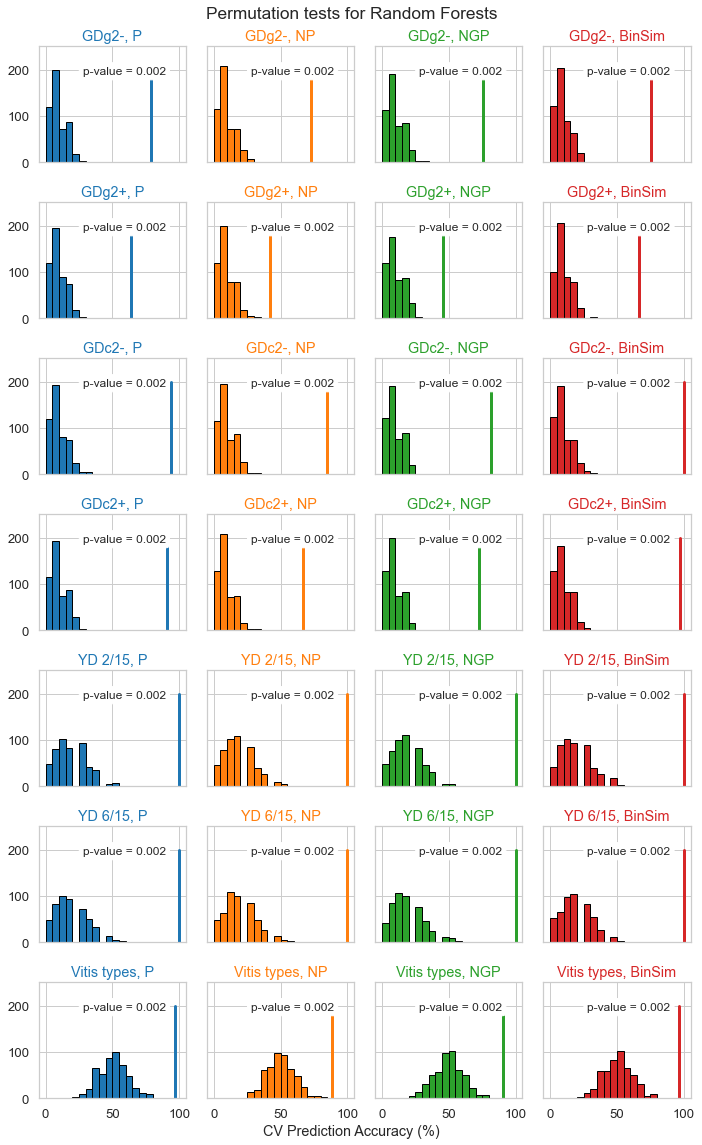

In [27]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, axes = plt.subplots(7, 4, figsize = (10,16), sharey='row', sharex='col')
        colors = sns.color_palette('tab10', 4)
        ylim = [0,200]
        treatments = ['P','NP','NGP','BinSim']
        
        for row, dskey in enumerate(datasets):

            to_plot = [p for p in permuts_RF if p['dataset'] == dskey]

            n_labels = len(datasets[dskey]['target'])

            for ax, p, tname, color in zip(axes[row].ravel(), to_plot, treatments, colors):
                ax.hist(np.array(p['permutations'])*100, range=(0, 100.01), label=name + ' Permutations',
                        bins=20, edgecolor='black', color=color)
                #ax.axvline(p['non_permuted_CV']*100)

                ax.plot(2 * [p['non_permuted_CV'] * 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
                         label=name + ' (pvalue %.5f)' % p['p-value'], solid_capstyle='round')
                #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences', fontsize=12)
                #ax.set_xlabel('CV Prediction Accuracy (%)')
                #ax.set_ylabel('Nº of occurrences')
                props = dict(boxstyle='round', facecolor='white', alpha=1)
                ax.text(90, 190, 'p-value = %.3f' % p['p-value'], bbox=props, ha='right', fontsize='small')
                ax.set_title(f"{datasets[dskey]['name']}, {tname}", color=color)
                ax.set_ylim(0,250)

        f.text(0.5, 0.01, 'CV Prediction Accuracy (%)', ha='center', va='top')
        #f.text(0, 0.5, 'Counts', ha='center', va='top',rotation=90)
        
        
        f.suptitle(f'Permutation tests for Random Forests')
        plt.tight_layout()
        f.savefig('paperimages/permutations_RF.pdf', dpi=200)
        f.savefig('paperimages/permutations_RF.png', dpi=600)
        plt.show()

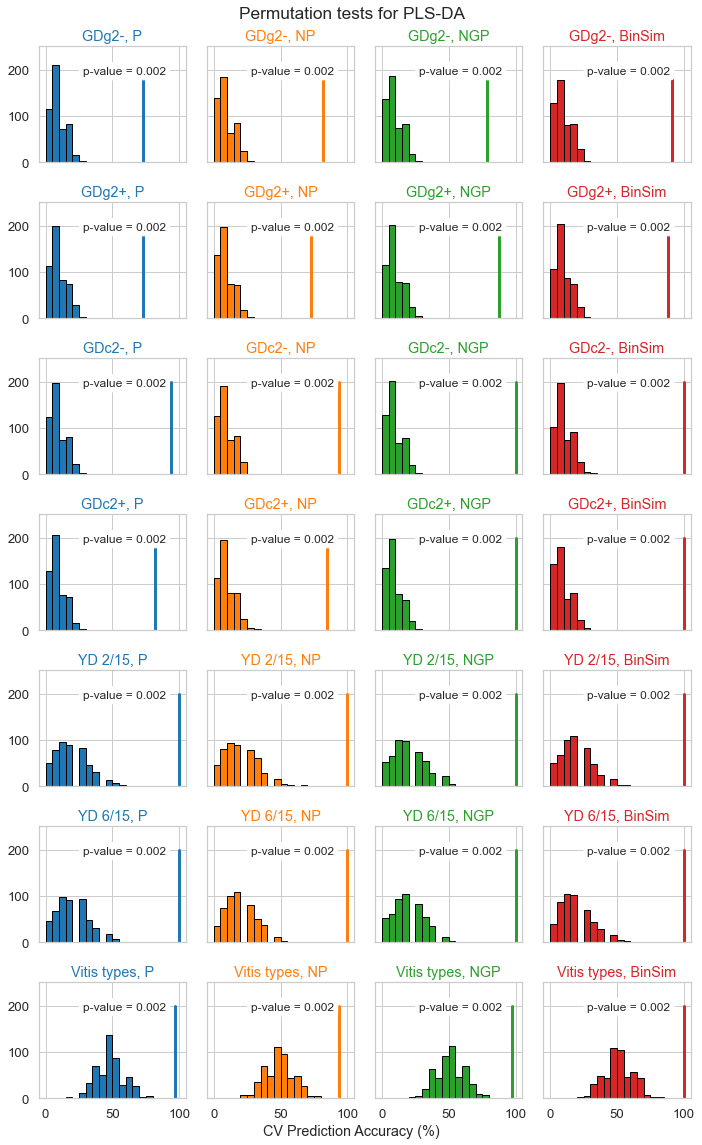

In [28]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, axes = plt.subplots(7, 4, figsize = (10,16), sharey='row', sharex='col')
        colors = sns.color_palette('tab10', 4)
        ylim = [0,200]
        treatments = ['P','NP','NGP','BinSim']
        
        for row, dskey in enumerate(datasets):

            to_plot = [p for p in permuts_PLSDA if p['dataset'] == dskey]

            n_labels = len(datasets[dskey]['target'])

            for ax, p, tname, color in zip(axes[row].ravel(), to_plot, treatments, colors):
                ax.hist(np.array(p['permutations'])*100, range=(0, 100.01), label=name + ' Permutations',
                        bins=20, edgecolor='black', color=color)
                #ax.axvline(p['non_permuted_CV']*100)

                ax.plot(2 * [p['non_permuted_CV'] * 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
                         label=name + ' (pvalue %.5f)' % p['p-value'], solid_capstyle='round')
                #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences', fontsize=12)
                #ax.set_xlabel('CV Prediction Accuracy (%)')
                #ax.set_ylabel('Nº of occurrences')
                props = dict(boxstyle='round', facecolor='white', alpha=1)
                ax.text(90, 190, 'p-value = %.3f' % p['p-value'], bbox=props, ha='right', fontsize='small')
                ax.set_title(f"{datasets[dskey]['name']}, {tname}", color=color)
                ax.set_ylim(0,250)

        f.text(0.5, 0.01, 'CV Prediction Accuracy (%)', ha='center', va='top')
        #f.text(0, 0.5, 'Counts', ha='center', va='top',rotation=90)
        
        
        f.suptitle(f'Permutation tests for PLS-DA')
        plt.tight_layout()
        f.savefig('paperimages/permutations_PLSDA.pdf', dpi=200)
        f.savefig('paperimages/permutations_PLSDA.png', dpi=600)
        plt.show()